#Imports/Permissions to load data

In [58]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#stuff we need
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.utils import get_custom_objects
from google.colab import drive
import h5py
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Reshape, Dropout, BatchNormalization
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import pickle


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Scaling

We load the training data agin just to redefine the scaling to use on test data

In [59]:
x_val, y_val=np.empty([0, 110006]), np.empty([0, 6])
filepath='./drive/Shareddrives/ML_project/Complete_Spectral_Data/Training_Data/finished_data0'

allfiles, testfiles=np.arange(100), np.arange(0, 100, 10)
trainmask=[False if num in testfiles else True for num in allfiles]
trainfiles=shuffle(allfiles[trainmask], random_state=2)
pickle.dump(trainfiles, open('fileorder', 'wb'))

sc_x, sc_y, sc_y_log=StandardScaler(), StandardScaler(), StandardScaler()

#This loading function is annoying and perhaps overly complicated, but basically, when preparing the data we accidentally left it in order of 
#stellar circularity fraction. So now we load 10 random files at a time, combine their entries, and randomly select part of our validation data 
#from this.
for i in range(0, 90, 10):
  x_chunk, y_chunk=np.empty([0, 110006]), np.empty([0, 6])
  for file in trainfiles[i:i+10]:
    file_obj=h5py.File(filepath+str(file)+'.hdf5', 'r')
    x, y=file_obj['Data']['x_values'], file_obj['Data']['y_values']
    x_chunk, y_chunk=np.concatenate((x_chunk, x)), np.concatenate((y_chunk, y))
  x_train, xv, y_train, yv=train_test_split(x_chunk, y_chunk, test_size=0.1, random_state=0)  #train_test_split also shuffles data
  y_train_log, y_val_log=np.log10(y_train), np.log10(y_val)
  y_train_log=np.where(y_train_log==np.log10(0), -1, y_train_log)
  x_val, y_val=np.concatenate((x_val, xv)), np.concatenate((y_val, yv))
  sc_x.partial_fit(x_train)
  sc_y.partial_fit(y_train)
  sc_y_log.partial_fit(y_train_log)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21:

#Load Models

We train our auto-encoder and final model using mini-batches. After each minibatch, we save the autoencoder. This allows us to resume training manually after disconnects. When we finally train our model we simply load the autoencoder. 

In [60]:
#LeakyReLU definition and model initialization
def leaky_relu(z,name=None):
  return tf.maximum(0.01*z, z, name=name)
get_custom_objects().update({'leaky_relu':leaky_relu})

log_ae_nn=keras.models.load_model('./drive/Shareddrives/ML_project/log_10f_70e/log_ae_nn.h5')
ae_nn=keras.models.load_model('./drive/Shareddrives/ML_project/ae_nn.h5')

#Load and Prepare Test Data

In [61]:
filepath='./drive/Shareddrives/ML_project/Complete_Spectral_Data/Test_Data/finished_data0'
x_values, y_values=np.empty([0, 110006]), np.empty([0, 6])
for i in range(0, 100, 10):
  file_obj=h5py.File(filepath+str(i)+'.hdf5', 'r')
  x, y=file_obj['Data']['x_values'], file_obj['Data']['y_values']
  x_values, y_values=np.concatenate((x_values, x)), np.concatenate((y_values, y))

x_test, y_test=shuffle(x_values, y_values)

In [62]:
y_test_log=np.log10(y_test)
y_test_log=np.where(y_test_log==np.log10(0), -1, y_test_log)
x_test_scaled, y_test_scaled, y_test_scaled_log=sc_x.transform(x_test), sc_y.transform(y_test), sc_y_log.transform(y_test_log)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


#Testing the Models

In [63]:
results = ae_nn.evaluate(x_test_scaled, y_test_scaled, batch_size=32)
results_log=log_ae_nn.evaluate(x_test_scaled, y_test_scaled_log)
print("test loss for non log model:", results)
print('\n test loss for log model:', results_log)
ae_nn_test_sc = sc_y.inverse_transform(ae_nn.predict(x_test_scaled))
ae_nn_test_sc_log=sc_y_log.inverse_transform(log_ae_nn.predict(x_test_scaled))

43/43 [==============================] - 3s 66ms/step - loss: 0.1798
test loss for non log model: 0.1692514419555664

 test loss for log model: 0.17981548607349396


In [64]:
max(y_val[:, -2]), max(ae_nn_test_sc[:, -2])

(5.53950413543788e+16, 2.3908447e+16)

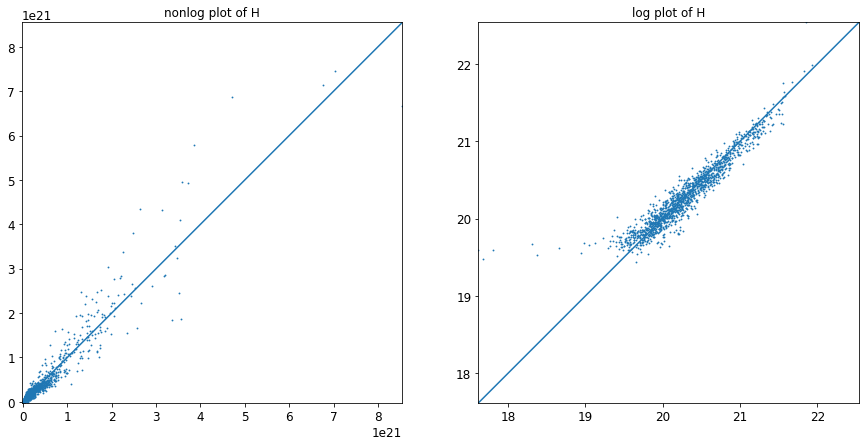

<Figure size 432x288 with 0 Axes>

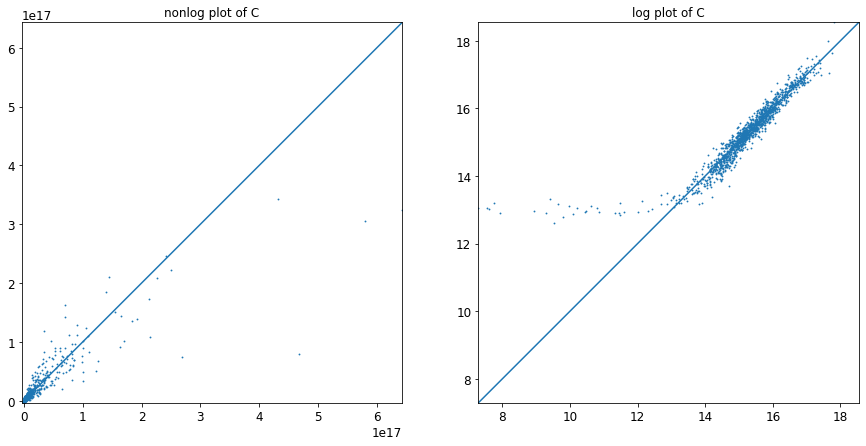

<Figure size 432x288 with 0 Axes>

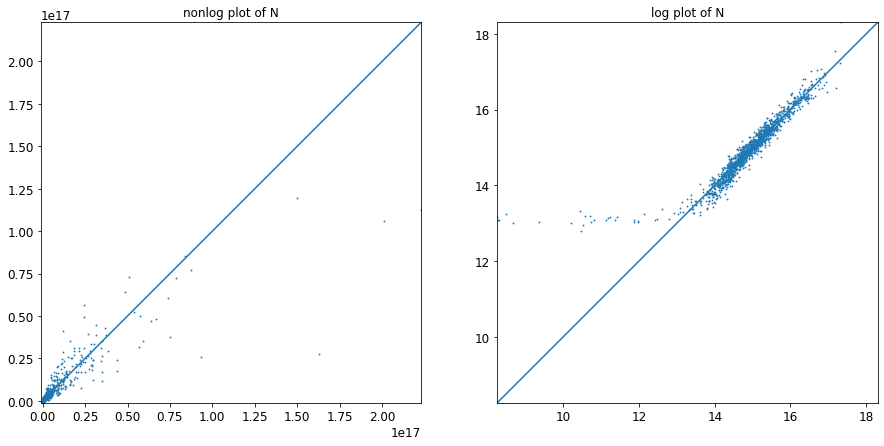

<Figure size 432x288 with 0 Axes>

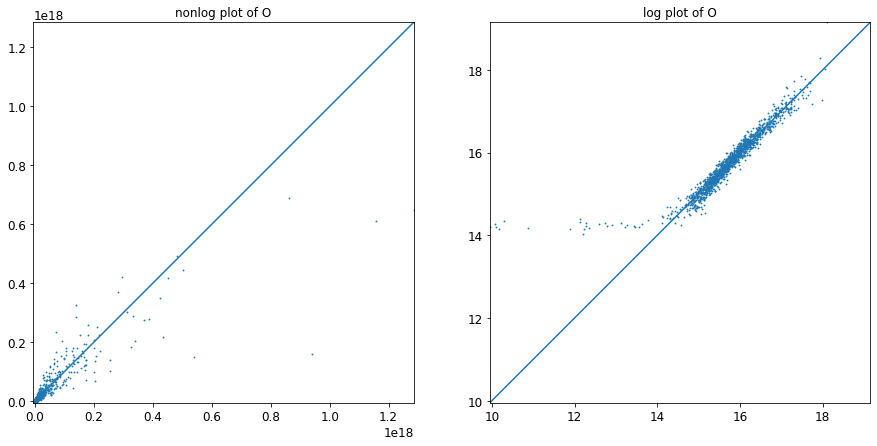

<Figure size 432x288 with 0 Axes>

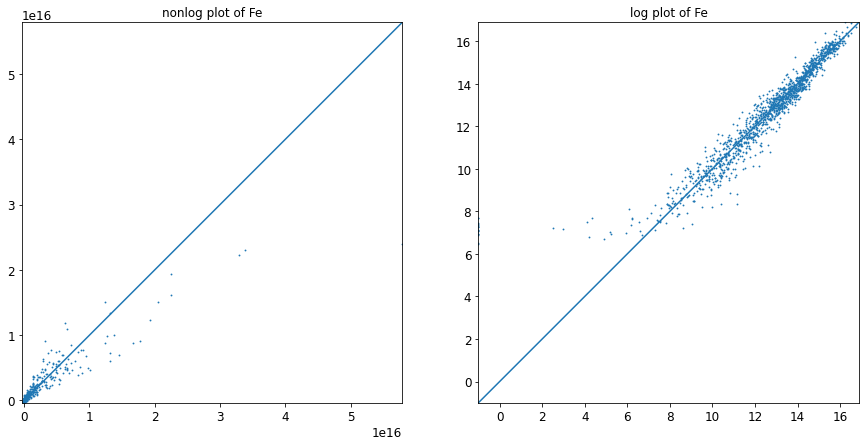

<Figure size 432x288 with 0 Axes>

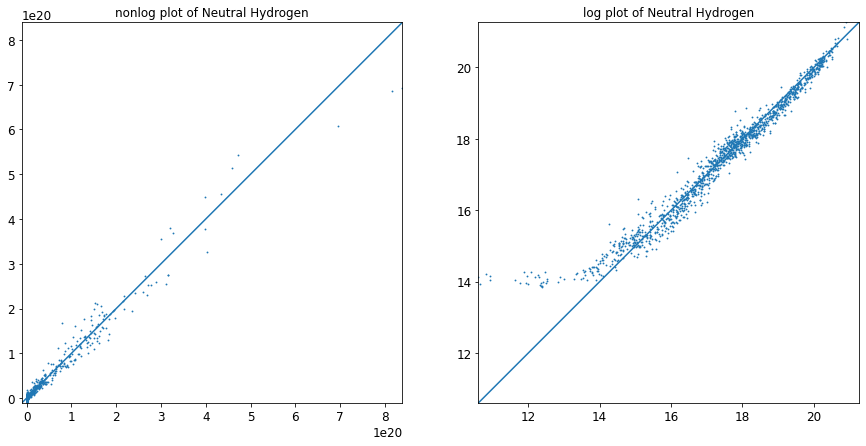

<Figure size 432x288 with 0 Axes>

In [67]:
from matplotlib.pyplot import figure
CDs=['H', 'C', 'N', 'O', 'Fe', 'Neutral Hydrogen']
for i in range(6):
  f, (ax0, ax1)=plt.subplots(1, 2, figsize=(15, 15))

  #non-log plots
  axis_limits=[min(min(y_test[:, i]), min(ae_nn_test_sc[:, i])), max(max(y_test[:, i]), max(ae_nn_test_sc[:, i]))]
  ax0.set_xlim(*axis_limits)
  ax0.set_ylim(*axis_limits)
  ax0.set_title('nonlog plot of '+CDs[i])
  ax0.set_aspect(aspect=1)
  ax0.scatter(y_test[:,i], ae_nn_test_sc[:,i], s=0.7)
  ax0.plot(np.linspace(*axis_limits), np.linspace(*axis_limits))

  #log plots
  axis_limits=[min(min(y_test_log[:, i]), min(ae_nn_test_sc_log[:, i])), max(max(y_test_log[:, i]), max(ae_nn_test_sc_log[:, i]))]
  ax1.set_xlim(*axis_limits)
  ax1.set_ylim(*axis_limits)
  ax1.set_title('log plot of '+CDs[i])
  ax1.set_aspect(aspect=1)
  ax1.scatter(y_test_log[:,i], ae_nn_test_sc_log[:,i], s=0.7)
  ax1.plot(np.linspace(*axis_limits), np.linspace(*axis_limits))
  plt.show()
  plt.clf()

In [66]:
y_test_scaled_log.shape

(1350, 6)